In [22]:
import os

import nibabel as nib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
import seaborn as sns

In [23]:
DATA_ROOT = os.environ['HOME'] + '/data'
DATASET_ROOT = DATA_ROOT + '/ribfrac'
TRAIN_ROOT = DATASET_ROOT + '/train'
VAL_ROOT = DATASET_ROOT + '/val'
ANALYSIS_ROOT = DATA_ROOT + '/analysis'

LABEL_CODE = {
    0: 'background',
    1: 'displaced',
    2: 'non-displaced',
    3: 'buckle',
    4: 'segmental',
    -1: 'undefined'
}


In [24]:
rib_frac_types = {name: 0 for name in LABEL_CODE.values()}
rib_data = defaultdict(list)
nr_frac = defaultdict(int)

info_files = [
    os.path.join(TRAIN_ROOT, 'ribfrac-train-info-1.csv'),
    os.path.join(TRAIN_ROOT, 'ribfrac-train-info-2.csv'),
    #os.path.join(VAL_ROOT, 'ribfrac-val-info.csv')
]
for info_file in info_files:
    for index, row in pd.read_csv(info_file).iterrows():
        public_id, label_id, label_code = row
        rib_data[public_id].append(label_code)
        nr_frac[public_id] += 1
        if label_code != 0:  # ignore background
            rib_frac_types[LABEL_CODE[label_code]] += 1
        
print('rib_data=', rib_data)
print('nr_frac=', nr_frac)  # nr_frac is just the len of each rib_data
#print(rib_frac_types)

total_rib_frac = sum(rib_frac_types.values())
avg_frac = total_rib_frac/len(nr_frac)
print('average fractures', avg_frac)
print('total fractures',total_rib_frac)

rib_data= defaultdict(<class 'list'>, {'RibFrac1': [0, 2, 2], 'RibFrac2': [0, -1, -1, -1, 2, 2, 2, -1, -1, -1], 'RibFrac3': [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 3], 'RibFrac4': [0, 2, 2, 1, 1, -1, 2], 'RibFrac5': [0, 2, 2], 'RibFrac6': [0, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1], 'RibFrac7': [0, 2, -1, 2, -1, -1, -1], 'RibFrac8': [0, 1, 1, 1, 4, 4, 2, -1, 2, 4, -1, -1], 'RibFrac9': [0, -1, -1, -1, -1, -1, 1, -1, -1, 1, 4, -1, -1, -1, 1, -1, -1], 'RibFrac10': [0, -1, -1, 3, -1, 3, 3, 1, 2], 'RibFrac11': [0, 3, 2], 'RibFrac12': [0, -1, -1, 2, 4, 4, 1], 'RibFrac13': [0, -1, -1, -1, 2, 1, -1, 1, -1, -1], 'RibFrac14': [0, -1, 1, -1, -1, -1, 2], 'RibFrac15': [0, -1, -1, -1, -1, -1, -1, -1, -1, -1], 'RibFrac16': [0, -1, -1, -1, -1, -1, 1, 3, 3, 1, 3, -1, -1, -1, -1, -1], 'RibFrac17': [0, 1, 1, 1, 1, 3, 1, -1, -1, -1, -1, 2, 3, -1, -1, -1, -1, -1, -1], 'RibFrac18': [0, -1, -1, -1, 1, 1, -1, -1, 3, 3], 'RibFrac19': [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 4, 

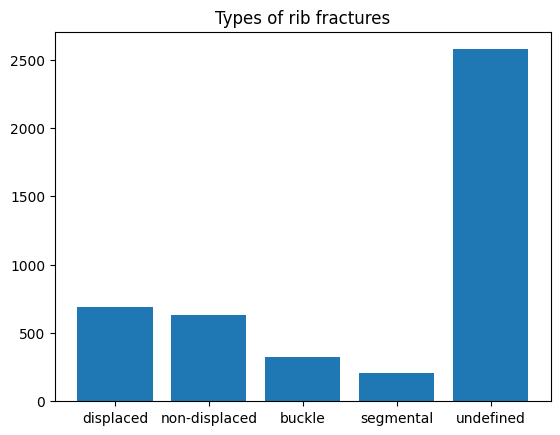

In [25]:
plt.bar(list(rib_frac_types.keys())[1:],list(rib_frac_types.values())[1:])
plt.title('Types of rib fractures')
plt.show()

In [40]:
# def get_axis(scan, label, idx):
#     min_x = -999
#     max_x = -999
#     min_y = -999
#     max_y = -999
# #     xs = []
# #     ys = []
#     for i, slice_ in enumerate(scan[idx[0]:idx[-1]+1]):
#         #frac = np.where(slice_ == label, 1, 0)
#         #xs.append(max(np.sum(frac, axis = 1)))
#         #ys.append(max(np.sum(frac, axis = 0)))
#         x, y = np.where(slice_ == label)
#         min_x, max_x, min_y, max_y = np.min(x), np.max(x), np.min(y), np.max(y)
#     if min_x == -999:
#         print(len(scan), idx, scan)
#     return min_x, max_x, min_y, max_y

def get_bbox(scan):
    """get the 3d bounding box of the volume. scan is binary boolean array with coords (z, x, y)"""
    z, x, y = np.where(scan)
    assert len(z) > 0, 'scan is empty'
    min_x, max_x, min_y, max_y, min_z, max_z = np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)
    return min_x, max_x, min_y, max_y, min_z, max_z

def get_max_xy_box(scan):
    """gets the largest window size that could contain the area of the facture in each slice. scan is binary boolean array with coords (z, x, y)"""
    xs = np.any(scan, axis=2, keepdims=True)  # any in y direction
    ys = np.any(scan, axis=1, keepdims=True)  # any in x direction
    size_x = np.sum(xs, axis=1, keepdims=True)  # sum in x direction
    size_y = np.sum(ys, axis=2, keepdims=True)  # sum in y direction
    size_x = np.max(size_x)  # largest x size
    size_y = np.max(size_y)  # largest y size
    return size_x, size_y

def get_volume(scan):
    """volume of the volume defined by the binary boolean array scan with coords (z, x, y)"""
    return np.sum(scan)

def get_xy_areas(scan):
    """gets minimum and maximum 2d areas through z-planes. scan is binary boolean array with coords (z, x, y)"""
    areas = np.sum(scan, axis=(1, 2))  # sum in x and y direction
    return np.min(areas), np.max(areas)

def center_of_mass(scan) -> tuple:
    """cneter of mass of the volume defined by the binary boolean array scan with coords (z, x, y)"""
    z, x, y = np.where(scan)
    assert len(z) > 0, 'scan is empty'
    com_z = np.mean(z)
    com_x = np.mean(x)
    com_y = np.mean(y)
    return com_z, com_x, com_y


def fracture_label_analysis(train_folder_path, rib_data):
    """
    Produces 2 dataframes with the following information:

    df_scan:
        public_id: id of the scan (e.g. 'RibFrac100')
        size_x: size of the scan in x-direction (height)
        size_y: size of the scan in y-direction (width)
        size_z: size of the scan in z-direction (depth)

    df_frac:
        public_id: id of the scan (e.g. 'RibFrac100')
        frac_idx: index of the fracture within the scan (natural number to count each fracture in each scan)
        frac_code: code of the fracture (integer code to identify the fracture type)
        frac_code_name: name of the fracture (string name of the fracture type, human readable frac_code)
        min_x: minimum x-value of the 3d bounding box the encloses the fracture (absolute values in pixels)
        max_x: maximum x-value of the 3d bounding box the encloses the fracture (absolute values in pixels)
        min_y: minimum y-value of the 3d bounding box the encloses the fracture (absolute values in pixels)
        max_y: maximum y-value of the 3d bounding box the encloses the fracture (absolute values in pixels)
        min_z: minimum z-value of the 3d bounding box the encloses the fracture (absolute values in pixels)
        max_z: maximum z-value of the 3d bounding box the encloses the fracture (absolute values in pixels)
        volume: volume of the fracture (number of voxels)
        com_x: x-value of the center of mass (absolute values in pixels, assuming uniform density)
        com_y: y-value of the center of mass (absolute values in pixels, assuming uniform density)
        com_z: z-value of the center of mass (absolute values in pixels, assuming uniform density)
        max2dsize_x: largest 2d bounding box in xy-plane (max window size that could fit the fracture in every slice)
        max2dsize_y: largest 2d bounding box in xy-plane (max window size that could fit the fracture in every slice)
        min2darea: minimum area in xy-plane (area of the smallest fracture slice)
        max2darea: maximum area in xy-plane (area of the largest fracture slice)
        size_x: size of the 3d bounding box in x-direction (absolute values in pixels)
        size_y: size of the 3d bounding box in y-direction (absolute values in pixels)
        size_z: size of the 3d bounding box in z-direction (absolute values in pixels)
        loc_x: location of the center of the 3d bounding box in x-direction (absolute values in pixels)
        loc_y: location of the center of the 3d bounding box in y-direction (absolute values in pixels)
        loc_z: location of the center of the 3d bounding box in z-direction (absolute values in pixels)
        rel_min_x: minimum x-value of the 3d bounding box the encloses the fracture (relative size w.r.t scan size)
        rel_max_x: maximum x-value of the 3d bounding box the encloses the fracture (relative size w.r.t scan size)
        rel_min_y: minimum y-value of the 3d bounding box the encloses the fracture (relative size w.r.t scan size)
        rel_max_y: maximum y-value of the 3d bounding box the encloses the fracture (relative size w.r.t scan size)
        rel_min_z: minimum z-value of the 3d bounding box the encloses the fracture (relative size w.r.t scan size)
        rel_max_z: maximum z-value of the 3d bounding box the encloses the fracture (relative size w.r.t scan size)
        rel_com_x: x-value of the center of mass (relative size w.r.t scan size, assuming uniform density)
        rel_com_y: y-value of the center of mass (relative size w.r.t scan size, assuming uniform density)
        rel_com_z: z-value of the center of mass (relative size w.r.t scan size, assuming uniform density)
        rel_size_x: size of the 3d bounding box in x-direction (relative size w.r.t scan size)
        rel_size_y: size of the 3d bounding box in y-direction (relative size w.r.t scan size)
        rel_size_z: size of the 3d bounding box in z-direction (relative size w.r.t scan size)
        rel_loc_x: location of the center of the 3d bounding box in x-direction (relative size w.r.t scan size)
        rel_loc_y: location of the center of the 3d bounding box in y-direction (relative size w.r.t scan size)
        rel_loc_z: location of the center of the 3d bounding box in z-direction (relative size w.r.t scan size)
    """
    scan_data = []
    frac_data = []

    for filename in tqdm(os.listdir(train_folder_path)[2:], desc='analyzing train data'):

        if not (filename.endswith("label.nii.gz") or filename.endswith("label.nii")):
            continue

        filepath = os.path.join(train_folder_path, filename)
        label_scan = nib.load(filepath).get_fdata().T.astype(int)
        
        public_id = filename.split('-')[0]
        scan_data.append([
            public_id,
            label_scan.shape[1],
            label_scan.shape[2],
            label_scan.shape[0],
        ])

        # data_dev = []
        # for slice_idx in range(len(label_scan)):
        #     unique_label_ids = np.unique(label_scan[slice_idx]).tolist()
        #     data_dev.append([slice_idx, unique_label_ids])
        # df_slices = pd.DataFrame(data_dev, columns=["slice_idx", "label_ids"])

        labels_per_slice = defaultdict(list)
        for slice_idx, slice in enumerate(label_scan):
            unique_label_ids = np.unique(slice).tolist()
            labels_per_slice[slice_idx] = unique_label_ids
            
        for frac_idx, frac_code in enumerate(rib_data[public_id]):

            # idx= list of slice indices where the fracture is present
            # idx = []
            # for ind in df_slices.index:
            #     if frac_idx in df_slices['label_ids'][ind]:
            #         idx.append(df_slices['slice_idx'][ind])
            # if idx == []:
            #     print('WARNING:', public_id, 'has no fracture')
            #     continue
            # idxs = sorted(idx)

            idxs = []
            for slice_idx, unique_label_ids in labels_per_slice.items():
                if frac_idx in unique_label_ids:
                    idxs.append(slice_idx)
            idxs = sorted(idxs)

            ## compute values

            reduced_scan = label_scan[idxs[0]:idxs[-1]+1]  # ease computation with only relevant slices
            min_x, max_x, min_y, max_y, min_z, max_z = get_bbox(reduced_scan == frac_idx)
            volume = get_volume(reduced_scan == frac_idx)
            max2dsize_x, max2dsize_y = get_max_xy_box(reduced_scan == frac_idx)
            min2darea, max2darea = get_xy_areas(reduced_scan == frac_idx)

            # compensate for reduced scan offset
            min_z += idxs[0]
            max_z += idxs[0]
            assert min_z == idxs[0], f'{min_z} != {idxs[0]}'
            assert max_z == idxs[-1], f'{max_z} != {idxs[-1]}'

            # again reduce scan to only relevant volume
            reduced_scan = label_scan[idxs[0]:idxs[-1]+1, min_x:max_x+1, min_y:max_y+1]
            com_z, com_x, com_y = center_of_mass(reduced_scan == frac_idx)  # com relative to chunk

            # compensate for reduced scan offset
            com_x += min_x
            com_y += min_y
            com_z += min_z

            ## store values
            
            frac_data.append([
                public_id,
                frac_idx,
                frac_code,
                LABEL_CODE[frac_code],
                # bounding box limits (absolute pixel values)
                min_x,
                max_x,
                min_y,
                max_y,
                min_z,
                max_z,
                # volume of fracture
                volume,
                # center of mass of chunk (absolute pixel values)
                com_x,
                com_y,
                com_z,
                # largest 2d bounding box in xy-plane
                max2dsize_x,
                max2dsize_y,
                # min and max area in xy-plane
                min2darea,
                max2darea,
            ])

    df_scan = pd.DataFrame(
        scan_data,
        columns=[
            "public_id",
            "size_x",
            "size_y",
            "size_z",
        ],
    )

    df_frac = pd.DataFrame(
        frac_data,
        columns=[
            "public_id",
            "frac_idx",
            "frac_code",
            "frac_code_name",
            # bounding box limits (absolute pixel values)
            "min_x",
            "max_x",
            "min_y",
            "max_y",
            "min_z",
            "max_z",
            # volume of fracture
            "volume",
            # center of mass of chunk (absolute pixel values)
            "com_x",
            "com_y",
            "com_z",
            # largest 2d bounding box in xy-plane
            "max2dsize_x",
            "max2dsize_y",
            # min and max area in xy-plane
            "min2darea",
            "max2darea",
        ],
    )
    
    for axis in ['x', 'y', 'z']:
        # size of bounding box
        df_frac['size_' + axis] = df_frac['max_' + axis] - df_frac['min_' + axis]
        # center of bounding box
        df_frac['loc_' + axis] = (df_frac['max_' + axis] + df_frac['min_' + axis]) / 2

    scan_sizes = df_scan.set_index('public_id')

    # relative dimensions
    attrs = ['min', 'max', 'com', 'size', 'loc']
    for attr in attrs:
        for axis in ['x', 'y', 'z']:
            abs_attr = attr + '_' + axis
            rel_attr = 'rel_' + abs_attr
            scan_size = scan_sizes.loc[df_frac['public_id'], 'size_' + axis].reset_index(drop=True)
            df_frac[rel_attr] = df_frac[abs_attr] / scan_size

    return df_scan, df_frac

In [41]:
exists = os.path.exists(os.path.join(ANALYSIS_ROOT, 'scan.csv'))
if exists:
    df_scan = pd.read_csv(os.path.join(ANALYSIS_ROOT, 'scan.csv'))
    df_frac = pd.read_csv(os.path.join(ANALYSIS_ROOT, 'frac.csv'))
else:
    df_scan, df_frac = fracture_label_analysis(TRAIN_ROOT, rib_data)
    os.makedirs(ANALYSIS_ROOT, exist_ok=True)
    df_scan.to_csv(os.path.join(ANALYSIS_ROOT, 'scan.csv'), index=False)
    df_frac.to_csv(os.path.join(ANALYSIS_ROOT, 'frac.csv'), index=False)


analyzing train data:   0%|          | 0/840 [00:05<?, ?it/s]


In [42]:
df_scan.head()

,public_id,size_x,size_y,size_z
0,RibFrac29,512,512,373


In [43]:
df_frac.head()

,public_id,frac_idx,frac_code,frac_code_name,min_x,max_x,min_y,max_y,min_z,max_z,...,rel_max_z,rel_com_x,rel_com_y,rel_com_z,rel_size_x,rel_size_y,rel_size_z,rel_loc_x,rel_loc_y,rel_loc_z
0,RibFrac29,0,0,background,0,511,0,511,0,372,...,0.997319,0.499030,0.498969,0.498656,0.998047,0.998047,0.997319,0.499023,0.499023,0.498660
1,RibFrac29,1,3,buckle,210,248,393,414,220,240,...,0.643432,0.451115,0.789787,0.619699,0.074219,0.041016,0.053619,0.447266,0.788086,0.616622
2,RibFrac29,2,1,displaced,209,240,396,414,193,212,...,0.568365,0.437403,0.791121,0.543508,0.060547,0.035156,0.050938,0.438477,0.791016,0.542895
3,RibFrac29,3,1,displaced,220,256,401,418,177,196,...,0.525469,0.462378,0.799819,0.499392,0.070312,0.033203,0.050938,0.464844,0.799805,0.500000
4,RibFrac29,4,1,displaced,239,277,405,423,159,181,...,0.485255,0.499157,0.808344,0.458326,0.074219,0.035156,0.058981,0.503906,0.808594,0.455764


In [44]:
df_scan.describe()

,size_x,size_y,size_z
count,1.0,1.0,1.0
mean,512.0,512.0,373.0
std,NaN,NaN,NaN
min,512.0,512.0,373.0
25%,512.0,512.0,373.0
50%,512.0,512.0,373.0
75%,512.0,512.0,373.0
max,512.0,512.0,373.0


In [45]:
df_frac.describe()

,frac_idx,frac_code,min_x,max_x,min_y,max_y,min_z,max_z,volume,com_x,...,rel_max_z,rel_com_x,rel_com_y,rel_com_z,rel_size_x,rel_size_y,rel_size_z,rel_loc_x,rel_loc_y,rel_loc_z
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2.000000,1.200000,175.600000,306.400000,319.000000,436.000000,149.800000,240.200000,1.955594e+07,240.546089,...,0.643968,0.469817,0.737608,0.523916,0.255469,0.228516,0.242359,0.470703,0.737305,0.522788
std,1.581139,1.095445,98.900455,115.201128,178.385818,42.089191,86.687369,76.851805,4.371841e+07,14.413488,...,0.206037,0.028151,0.133612,0.061441,0.415151,0.430191,0.422048,0.029693,0.133445,0.060833
min,0.000000,0.000000,0.000000,240.000000,0.000000,414.000000,0.000000,181.000000,2.936000e+03,223.950173,...,0.485255,0.437403,0.498969,0.458326,0.060547,0.033203,0.050938,0.438477,0.499023,0.455764
25%,1.000000,1.000000,209.000000,248.000000,393.000000,414.000000,159.000000,196.000000,4.616000e+03,230.971049,...,0.525469,0.451115,0.789787,0.498656,0.070312,0.035156,0.050938,0.447266,0.788086,0.498660
50%,2.000000,1.000000,210.000000,256.000000,396.000000,418.000000,177.000000,212.000000,4.814000e+03,236.737640,...,0.568365,0.462378,0.791121,0.499392,0.074219,0.035156,0.053619,0.464844,0.791016,0.500000
75%,3.000000,1.000000,220.000000,277.000000,401.000000,423.000000,193.000000,240.000000,5.538000e+03,255.503146,...,0.643432,0.499030,0.799819,0.543508,0.074219,0.041016,0.058981,0.499023,0.799805,0.542895
max,4.000000,3.000000,239.000000,511.000000,405.000000,511.000000,220.000000,372.000000,9.776181e+07,255.568436,...,0.997319,0.499157,0.808344,0.619699,0.998047,0.998047,0.997319,0.503906,0.808594,0.616622


<AxesSubplot:xlabel='size_x', ylabel='Count'>

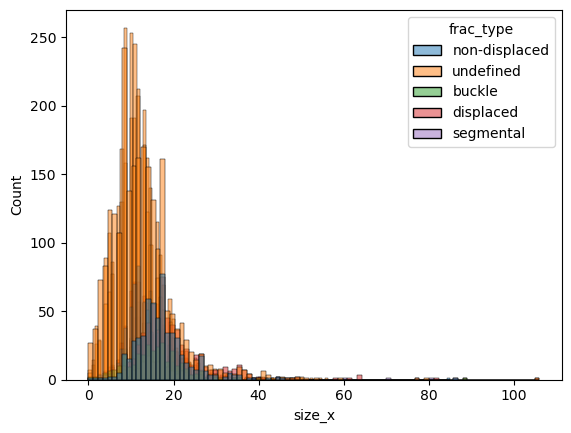

In [ ]:
# src: https://seaborn.pydata.org/generated/seaborn.histplot.html
sns.histplot(data=data, x="size_x", hue="frac_type")
sns.histplot(data=data, x="size_y", hue="frac_type")
sns.histplot(data=data, x="size_z", hue="frac_type")

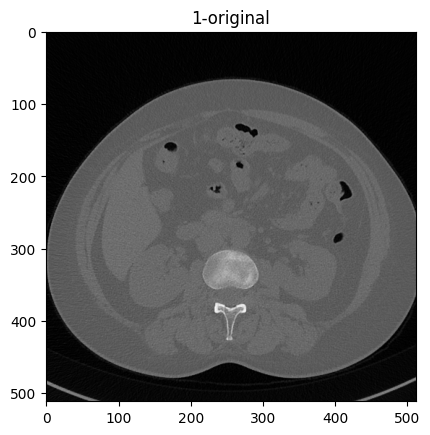

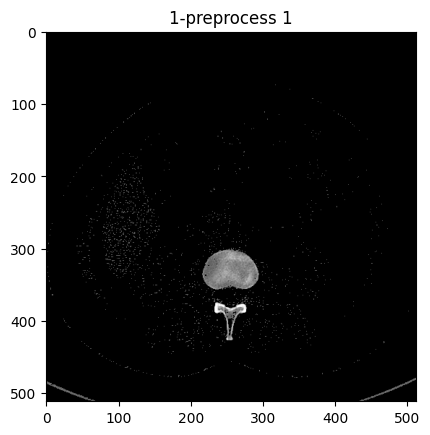

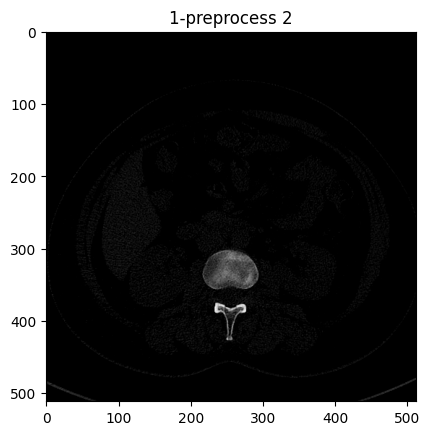

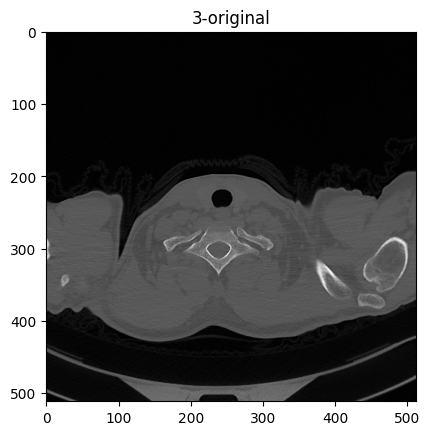

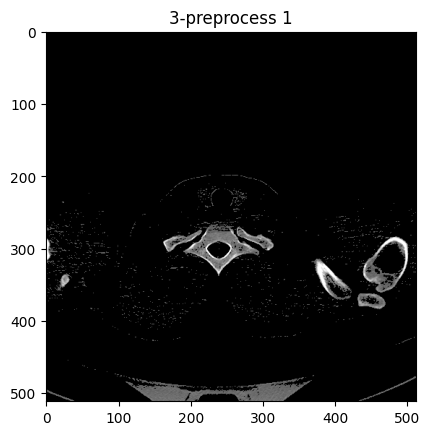

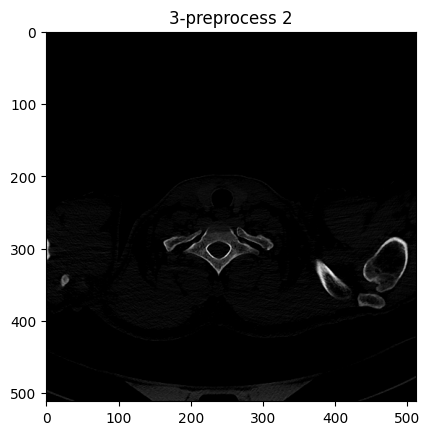

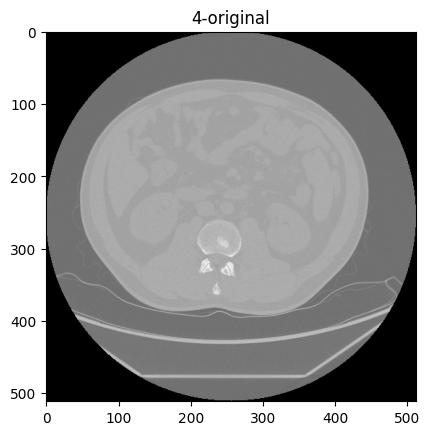

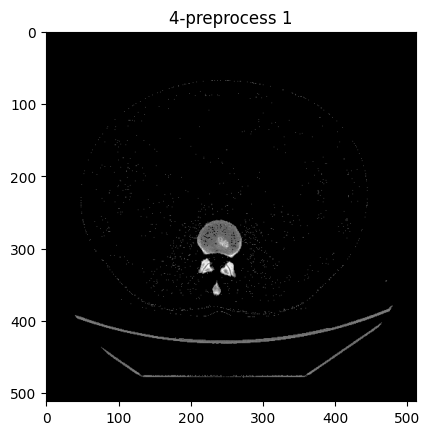

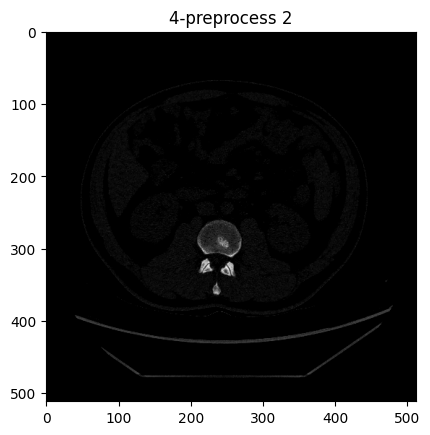

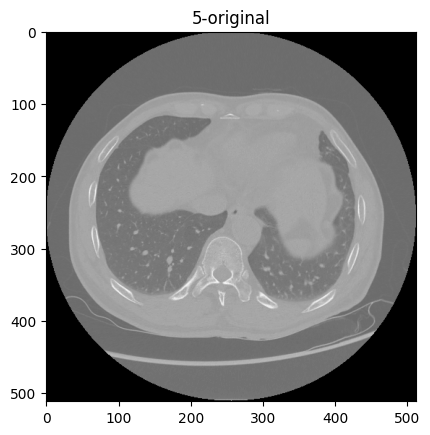

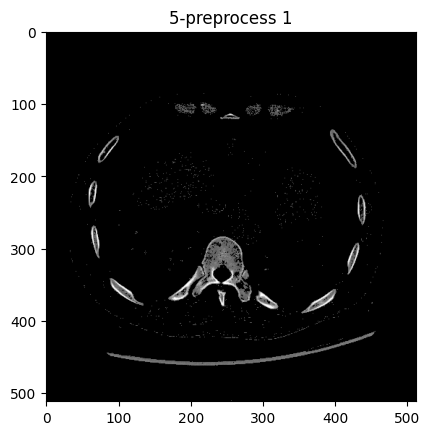

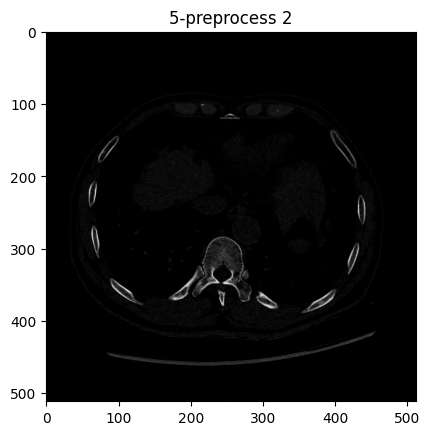

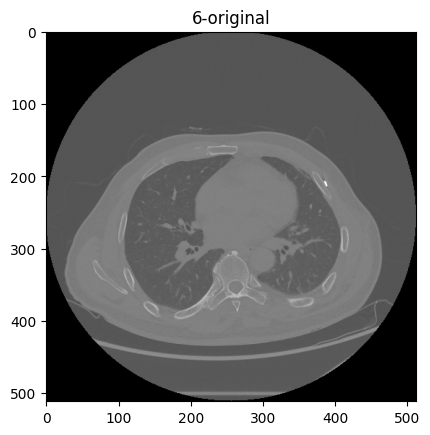

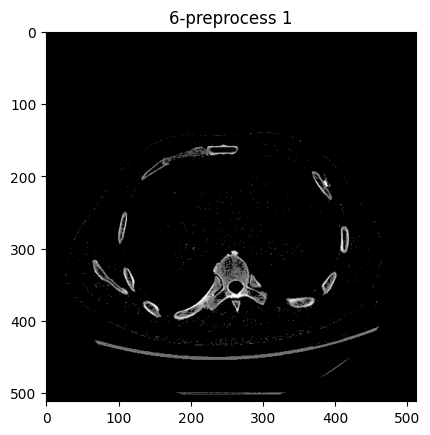

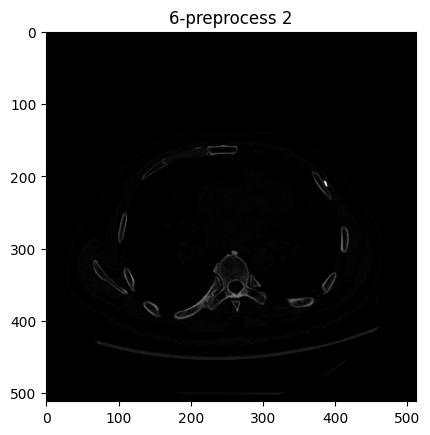

In [ ]:
# preprocessing
level = 0.5
window = 0.1
trheshold = 0.8

def preprocess1(img, level=400, window=1800, threshold=0.35):
    max_ = level + window/2
    min_ = level - window/2
    img = img.clip(min_, max_)
    img = (img - min_) / (max_ - min_)
    img[img < threshold] = 0
    return img

def preprocess2(img, threshold=0):
    img = img.copy()
    img[img < threshold] = 0
    return img

def show(img, title=None):
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()

for n, filename in enumerate(os.listdir(TRAIN_ROOT)[:10]):
    if 'label' in filename:
        continue
    path = os.path.join(TRAIN_ROOT, filename)
    scan = nib.load(path).get_fdata().T.astype(float)  # (z, x, y)
    slice_idx = np.random.randint(0, scan.shape[0])
    slice_ = scan[slice_idx]
    show(slice_, f'{n}-original')
    show(preprocess1(slice_), f'{n}-preprocess 1')
    show(preprocess2(slice_), f'{n}-preprocess 2')

In [ ]:
# scan pixel values analysis

class Histogram:
    def __init__(self, bins, vmin=0, vmax=1) -> None:
        self.hist = np.zeros(bins)
        self.vmin = vmin
        self.vmax = vmax

    def add(self, values):
        values = np.clip(values, self.vmin, self.vmax)
        values = (values - self.vmin) / (self.vmax - self.vmin)
        values = (values * (len(self.hist) - 1)).astype(int)
        self.hist[values] += 1
        # OR:
        # self.hist += np.histogram(values, bins=self.hist.shape, range=(self.vmin, self.vmax))[0]
        pass  # TODO: test this

    def add_in_position(self, amounts, positions):
        pass  # TODO: positions might not correspond with the bins of the histogram


def scan_bone_height_analysis(train_folder_path, df_scan, fn_thresholder):
    """
    Args:
        train_folder_path: path to the train folder
        df_scan: dataframe with scan information (see fracture_label_analysis, it must contain scan sizes)
        fn_thresholder: function that takes a scan and returns a thresholded scan (binary boolean array with coords (z, x, y))
    """

    # initialize histograms
    abs_heights = defaultdict(int)  # TODO: use Histogram class
    rel_heights = defaultdict(int)

    for filename in tqdm(os.listdir(train_folder_path)[2:], desc='analyzing pixel heights'):

        if not (filename.endswith("image.nii.gz") or filename.endswith("image.nii")):
            continue

        # read scan
        filepath = os.path.join(train_folder_path, filename)
        scan = nib.load(filepath).get_fdata().T.astype(float)

        # threshold scan
        scan_bin = fn_thresholder(scan)
        
        bones_z = np.sum(scan_bin, axis=(1, 2))
        heights = np.arange(scan.shape[0])
        pass  # TODO: add to histogram

        # get scan size
        public_id = filename.split('-')[0]
        _, _, size_z = df_scan.set_index('public_id').loc[public_id].values
        rel_heights = heights / size_z
        pass  # TODO: add to histogram

    # TODO: return histograms and finish
